In [226]:
import pandas as pd
from io import StringIO
import re
import numpy as np
import sys
sys.path.append('C:/Users/aurel/Downloads/HS23/CIR/Automatic-Cart-Unity/Assets/Code/Application/ImageToGraph')
from utils import *
pd.set_option('mode.chained_assignment', None)
from PIL import Image
import os
import glob
from tqdm import tqdm
import networkx as nx

def elaborate_test(filepath_log:str, filpath_App:str, data_dict:dict, user_id:str, first_test:bool):

    data_dict['user_id'].append(user_id)

    with open(filpath_App, 'r') as file:  
        data = file.read()

    # Read data into a DataFrame
    df_app = pd.read_csv(StringIO(data), sep=' - ', header=None, engine='python')
    df_app.columns = ['Timestamp', 'Data']

    df_app['Timestamp'] = pd.to_datetime(df_app['Timestamp'], format='%d/%m/%Y_%H:%M:%S')

    #Time when world was created
    world_init = df_app.loc[df_app['Data'].str.contains('World Init')]['Timestamp'].max()
    data_dict['world_init'].append(world_init)

    #Get the line where the partecipants submits the food
    max_idx = df_app.loc[df_app['Data'].str.contains('Previous')].index.min()-1 

    #When the items where sent to unity
    items_submission = df_app.iloc[max_idx]['Timestamp']
    data_dict['items_submission'].append(items_submission)
    items_data = df_app.iloc[max_idx]['Data']
    match = re.search(r'products:(.*?)(?=\|)', items_data)
    products_string = match.group(1)
    products_list = products_string.split('&')
    data_dict['products_list'].append(products_list)
    data_dict['num_items'].append(len(products_list))

    string = df_app.loc[df_app['Data'].str.contains('mode')].iloc[0]['Data']
    test_mode = re.search(r'mode:([^|]+)', string).group(1)
    data_dict['test_mode'].append(test_mode)

    #-----------------------------------------------------------Elaborate Log file

    with open(filepath_log, 'r') as file:
        data = file.read()

    # Read data into a DataFrame
    df = pd.read_csv(StringIO(data), sep=' - ', header=None, engine='python')
    df.columns = ['Timestamp', 'Data']
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y_%H:%M:%S')

    # Split data into different categories
    lidar_df = df[df['Data'].str.startswith('Lidar data')].reset_index(drop=True)
    user_df = df[df['Data'].str.startswith('User data')].reset_index(drop=True)
    product_df = df[df['Data'].str.startswith('Product data')].reset_index(drop=True)
    robot_df = df[df['Data'].str.startswith('Robot data')].reset_index(drop=True)
    path_df = df[df['Data'].str.startswith('Path data')].reset_index(drop=True)

    dataframes = [lidar_df,user_df,product_df,robot_df,path_df]

    for df in dataframes:
        columns = re.findall(r'\|([^:]+):', df.iloc[0,1])
        columns.insert(0,'to_drop') 
        df[columns] = df['Data'].apply(lambda x: re.sub(r'\|.*?:', '|', x).strip('|')).str.split('|', expand=True)  
        df.drop(columns=['to_drop','Data'],inplace=True)

    
    bool_cols = ['userInPath', 'sthBack','detect1', 'detect2', 'detect3', 'detect4', 'detect5','detect1b', 'detect2b', 'detect3b', 'detect4b', 'detect5b']
    lidar_df[bool_cols] = lidar_df[bool_cols].replace({'True': True, 'False': False})


    float32_columns_user = ['userSpeed', 'userRotX', 'userRotY', 'userRotZ', 'userRotW', 'userLocX', 'userLocY', 'userLocZ']
    user_df[float32_columns_user] = user_df[float32_columns_user].replace(',', '.', regex=True).astype('float32')

    float32_columns_robot = ['robotOrientationX', 'robotOrientationY', 'robotOrientationZ', 
                            'robotLocX', 'robotLocY', 'robotLocZ', 'linearVel', 'angularVel']
    robot_df[float32_columns_robot] = robot_df[float32_columns_robot].replace(',', '.', regex=True).astype('float32')
    robot_df['grounded'] = robot_df['grounded'].replace({'True': True, 'False': False})

    product_df[['Count', 'CollCount']] = product_df[['Count', 'CollCount']].astype('int8')

    #Get the ideal length (if partecipant didn't go to the end then remove that from the distance)
    _,coordinates,ideal_lenght = hamiltonian_path(graph, products_list)
    final_pos = user_df.iloc[-1]
    if (final_pos['userLocX']-57.1338)**2 + (final_pos['userLocZ']-14.55)**2 > 3:
        ideal_length = ideal_lenght - nx.dijkstra_path_length(graph, coordinates[-1], coordinates[-2], weight='weight')
    data_dict['ideal_lenght'].append(ideal_lenght)


    #Distance walked by the user
    distance_walked_user = np.sqrt((user_df['userLocX'].diff())**2 + (user_df['userLocZ'].diff())**2).sum()/1.2
    data_dict['distance_walked_user'].append(distance_walked_user)

    #Timestamp of when last item is collected
    timestamp_last_item = product_df.loc[product_df['CollCount']==product_df['CollCount'].max()]['Timestamp'].min()
    data_dict['timestamp_last_item'].append(timestamp_last_item)  

    #Check if all items where collected
    data_dict['collected_all'].append(product_df['CollCount'].max()==len(products_list)) 

    #Timestamp of first movement (Start from when at least one unit away from the starting positions)
    timestamp_first_movement = user_df.loc[(user_df['userLocX']-50.63)**2 + (user_df['userLocZ']-11.73)**2 > 1]['Timestamp'].min()
    data_dict['timestamp_first_movement'].append(timestamp_first_movement) 

    if first_test:
        #Add how much the cart traveled
        distance_traveled_cart = np.sqrt((robot_df['robotLocX'].diff())**2 + (robot_df['robotLocZ'].diff())**2).sum()/1.2
        data_dict['distance_traveled_cart'].append(distance_traveled_cart) 

        #How many collisions where detected
        collision_amount = lidar_df.drop(columns='Timestamp').sum().sum()
        data_dict['collision_amount'].append(collision_amount) 

        num_interactions = len(df_app.loc[df_app['Data'].str.contains('Next Item') | df_app['Data'].str.contains('FollowMe') | df_app['Data'].str.contains('Pause')])
        data_dict['num_interactions'].append(num_interactions)
        

    """
    Relevant informations (Two different CSV for before and after):
    Testing Mode
    User_Id 
    Time of the first movement (Maybe consider out of some bound)
    Time of the last item to be collected
    (- Time to collect all the items/the number of items)
    List of items selected
    Time when the person finished to select the items
    (- How much time it took to select the items/the number of items)
    Time when the map was selected
    How long did the person walk
    - Ideal length of path
    ------------ (For second test)
    Robot Collisions
    How many interactions with the robot (vs. items)
    How much did the robot travel
    """

dir = 'C:/Users/aurel/Downloads/HS23/CIR/Automatic-Cart-Unity/Assets/Code/Application/ImageToGraph/'
imagedir = dir+'Model3.png'
image = np.array(Image.open(imagedir).convert('RGB')) #Remember that it reads row by row
image = image[10:210,10:210,:] #Keep only the superkarmet plan inside the frame  C:\Users\aurel\Downloads\HS23\CIR\ImageToGraph\Model3.png
graph = create_graph(image)


first_dict = {'user_id': [], 'world_init': [], 'items_submission': [], 'products_list': [], 'test_mode': [],
              'distance_walked_user': [],'timestamp_last_item': [], 'timestamp_first_movement': [],
              'ideal_lenght': [], 'collected_all': [], 'num_items': []} 

second_dict = {'user_id': [], 'world_init': [], 'items_submission': [], 'products_list': [], 'test_mode': [],
              'distance_walked_user': [],'timestamp_last_item': [], 'timestamp_first_movement': [],
              'ideal_lenght': [], 'distance_traveled_cart': [], 'collision_amount': [], 'num_interactions': [],
              'collected_all': [], 'num_items': []} 


# Get the current directory
current_directory = os.getcwd()

# List all folders in the current directory starting with 'test'
partecipants_folders = [os.path.join(current_directory, folder) for folder in os.listdir(current_directory) if os.path.isdir(os.path.join(current_directory, folder)) and folder.startswith('test')]


for partecipant in tqdm(partecipants_folders):
    partecipant_id = partecipant.split('\\')[-1].strip('test ')

    #Weird formatting of this 
    if partecipant_id == 'AC2':
        continue

    # Get all txt files inside the folder
    txt_files = glob.glob(os.path.join(partecipant, '*.txt'))
    elaborate_test(txt_files[2], txt_files[0], first_dict, partecipant_id, False)
    elaborate_test(txt_files[3], txt_files[1], second_dict, partecipant_id, True) 

100%|██████████| 13/13 [01:26<00:00,  6.65s/it]


In [227]:
first_run = pd.DataFrame(first_dict)
second_run = pd.DataFrame(second_dict)

for df in [first_run,second_run]:
    df['adjusted_time_shopping'] = (df['timestamp_last_item'] - df['timestamp_first_movement']).dt.total_seconds()/df['ideal_lenght']
    df['seconds/item_list'] = (df['items_submission'] - df['world_init']).dt.total_seconds()/df['num_items']
    df['travel_efficiency'] = df['distance_walked_user']/df['ideal_lenght']

second_run['cart_travel_efficiency'] = second_run['distance_traveled_cart']/df['ideal_lenght']

first_run.to_csv('first_runs.csv', index=False)
second_run.to_csv('second_runs.csv', index=False)

Data Analysis

    speedups user_id test_mode                     bin
0   3.667331     AC1         A               2x faster
1   1.446306     AC3         A             1.5x faster
2   2.151583     AC4         A               2x faster
3   2.003713     AC5         B               2x faster
4   0.940160     AC6         B                The same
5   1.399726     AC7         B                The same
6   0.500454     AN1         A             1.5x slower
7   0.229087     AN2         B  Over 2x slower or more
8   1.978811     LH1         A             1.5x faster
9   0.235222     LH2         B  Over 2x slower or more
10  1.647177     LH3         A             1.5x faster
11  0.363464     LH4         B  Over 2x slower or more


C:\Users\aurel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aurel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\aurel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is 

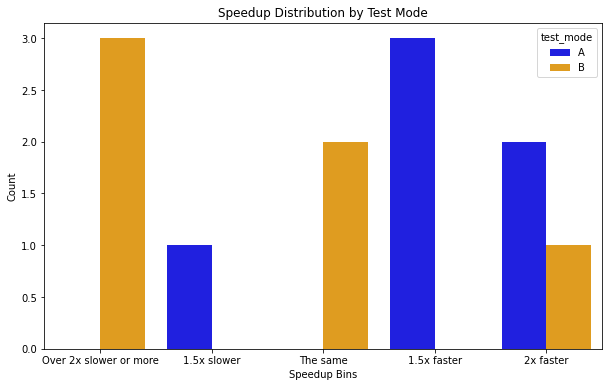

In [247]:
import seaborn as sns
import matplotlib.pyplot as plt
#Observed Speedups in travelling the supermarket
speedups = pd.DataFrame()
speedups['speedups'] = first_run['adjusted_time_shopping']/second_run['adjusted_time_shopping']
speedups[['user_id','test_mode']] = first_run[['user_id','test_mode']]

# Define bin bounds
bin_bounds = [0,0.5,0.7,1.4,2,4]

# Create a new column for bins
speedups['bin'] = pd.cut(speedups['speedups'], bins=bin_bounds, labels=['Over 2x slower or more', '1.5x slower', 'The same', '1.5x faster','2x faster'])
print(speedups)
# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.countplot(x='bin', hue='test_mode', data=speedups, palette={'A': 'blue', 'B': 'orange'})
plt.title('Speedup Distribution by Test Mode')
plt.xlabel('Speedup Bins')
plt.ylabel('Count')
plt.show()

In [228]:
intro_quest = pd.read_csv('Introduction Questionnaire.csv')
after_quest = pd.read_csv('After Questionnaire.csv')